# Tutorial 5 : Charge Resolution

This notebook demonstrates a very basic Charge Resolution investigation. It simulates a uniform illumination source, with no NSB and no electronic noise. The charge is extracted from the waveform by integrating the full waveform. Due to its simplicity, the result of the Charge Resolution only describes the photosensor Excess Noise Factor component and the poisson fluctions of the photons. This result is therefore analytically calculable from the `SPESpectrum`, and demonstrated alongside the final result.

In [1]:
from sstcam_simulation import Camera, PixelMapping, PhotoelectronSource, EventAcquisition
from CHECLabPy.utils.resolutions import ChargeResolution
from tqdm import tqdm, trange
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Define the camera
camera = Camera(
    pixel=PixelMapping(n_pixels=1),
    continuous_readout_length=128,
    #n_waveform_samples=128,
)
n_pixels = camera.pixel.n_pixels
pixel_array = np.arange(n_pixels)

In [3]:
source = PhotoelectronSource(camera=camera)
acquisition = EventAcquisition(camera=camera)
charge_resolution = ChargeResolution(mc_true=True)
n_events = 100
for illumination in tqdm(np.logspace(1, 3, 100)):
    for iev in range(n_events):
        pe = source.get_uniform_illumination(time=60, illumination=illumination)
        readout = acquisition.get_continuous_readout(pe)
        waveform = acquisition.get_sampled_waveform(readout)
        
        # Charge Extraction
        measured_charge = waveform.sum(1)
        
        true_charge = pe.get_photoelectrons_per_pixel(n_pixels)
        charge_resolution.add(pixel_array, true_charge, measured_charge)

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


In [4]:
df, _ = charge_resolution.finish()

In [5]:
def bin_dataframe(df, n_bins=40):
    true = df['true'].values
    min_ = true.min()
    max_ = (true.max() // 500 + 1) * 500
    bins = np.geomspace(0.1, max_, n_bins)
    bins = np.append(bins, 10**(np.log10(bins[-1]) + np.diff(np.log10(bins))[0]))
    df['bin'] = np.digitize(true, bins, right=True) - 1

    log = np.log10(bins)
    between = 10**((log[1:] + log[:-1]) / 2)
    edges = np.repeat(bins, 2)[1:-1].reshape((bins.size-1 , 2))
    edge_l = edges[:, 0]
    edge_r = edges[:, 1]
    df['between'] = between[df['bin']]
    df['edge_l'] = edge_l[df['bin']]
    df['edge_r'] = edge_r[df['bin']]

    return df

In [6]:
df = bin_dataframe(df, n_bins=40)

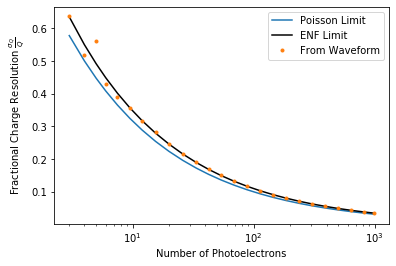

In [7]:
df_mean = df.groupby('bin').mean()
bin_ = df_mean.index
x = df_mean['true'].values
y = df_mean['charge_resolution'].values

poisson_limit = np.sqrt(x) / x
enf_limit = np.sqrt(camera.photoelectron_spectrum.excess_noise_factor * x) / x

plt.plot(x, poisson_limit, label="Poisson Limit")
plt.plot(x, enf_limit, label="ENF Limit", color='black')
plt.plot(x, y, '.', label="From Waveform")
plt.legend(loc="best")
plt.xlabel("Number of Photoelectrons")
plt.ylabel(r"Fractional Charge Resolution $\frac{{\sigma_Q}}{{Q}}$")
plt.xscale('log')